This notebook is written to compare the c++ octree implementation for fixed neighbour search (available [here](https://github.com/jbehley/octree)). This is an adhoc comparison between the c++ code and python implementation of KDtree in MdAnalysis. It is done by generating files for different number of coordinates distributed uniformly in a [100,100,100] box. These files are then read by the C++ octree code, and respective build tiime and query times are resported for same coordinates dataset.

In [1]:
import numpy as np
from collections import defaultdict

In [2]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

def _check_box(box):
        return box[:3] if box.shape == (6,) else box    

In [9]:
BOX = np.array([100.,100.,100.,90,90,90],dtype=np.float32)
CUTOFF = 10
NPOINTS = np.logspace(2, 5, num = 10, dtype = np.int)

In [10]:
for item in NPOINTS:
    coords = get_coords(BOX, item)
    np.savetxt('test'+str(item)+'.txt',coords)

KDTree used from previous benchmarks direclty, where it was tested against brute force and cellgrid. 

In [11]:
from MDAnalysis.lib.pkdtree import PeriodicKDTree
def kdtree_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def kdtree_query(struct, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

We only check the query at the midpoint of the box and cutoff radius of 10 units.

In [13]:
#coords = np.loadtxt('test.txt',dtype = np.float32)
pos = BOX[:3]/2
pos

array([50., 50., 50.], dtype=float32)

# Single Query

In [16]:
res = defaultdict(list)
for item in NPOINTS:
    coords = np.loadtxt('test'+str(item)+'.txt',dtype = np.float32)
    build = %timeit -o kdtree_build(BOX, coords)
    res['build'].append(build.average)
    
    pkdt = kdtree_build(BOX,coords)
    query = %timeit -o kdtree_query(pkdt, pos, CUTOFF)
    res['query'].append(query.average)
    res['N'].append(item)

106 µs ± 5.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
89.4 µs ± 6.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
202 µs ± 9.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
104 µs ± 9.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
420 µs ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
110 µs ± 9.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
110 µs ± 5.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.29 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
122 µs ± 4.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.56 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
145 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15.4 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
153 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10000 

# Data collected from outside the notebook

In [26]:
res_octree = defaultdict(list)
res_octree['build'] = [0.000035900, 0.000085800, 0.000157700, 0.000229500, 
                           0.001341700, 0.002891500, 0.002448400, 0.008294600,
                           0.017574700, 0.038262600]
res_octree['query'] = [0.000052300, 0.000088600, 0.000058300, 0.000050400 , 0.000126900, 
                       0.000096600, 0.000070400, 0.000115700, 0.000162800, 0.000237400]
res_octree['N'] = res['N']

In [27]:
res

defaultdict(list,
            {'build': [0.00010625211428574143,
              0.00020243374285714057,
              0.0004204029999998186,
              0.0010005411428572707,
              0.002294972857141277,
              0.006560897142855017,
              0.015437699999998325,
              0.040997471428558384,
              0.1028760714285454,
              0.24747571428568854],
             'query': [8.936121428571694e-05,
              0.00010360277142858001,
              0.00010964991428570232,
              0.00010961948571430184,
              0.00012177345714287314,
              0.00014504842857136934,
              0.00015315087142857268,
              0.0002980545714285004,
              0.00031735785714291913,
              0.0006185525714285437],
             'N': [100,
              215,
              464,
              1000,
              2154,
              4641,
              10000,
              21544,
              46415,
              100000]})

All the points within Cutoff distance


# Comparison between Octree and KDtree


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

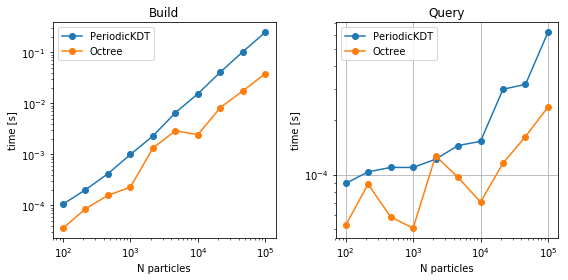

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2))

ax = axes[0]
ax.plot(res['N'], res['build'], 'o-', label='PeriodicKDT')
ax.plot(res_octree['N'], res_octree['build'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[1]
ax.plot(res['N'], res['query'], 'o-', label='PeriodicKDT')
ax.plot(res_octree['N'], res_octree['query'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.grid(True)
ax.legend()

fig.tight_layout()

OCtree with index based construction is a promising data structure to replace distance based calculations.  

# Lets check the variation with cutoff radius

To see the variation, which is useful for the general use cases in MDAnalysis, lets chose number of particles to be ~40k from above. 

In [32]:
cutoff = np.linspace(2,10,num = 9, dtype = np.float32)

In [33]:
res = defaultdict(list)
coords = np.loadtxt('test'+str(NPOINTS[8])+'.txt',dtype = np.float32)
for item in cutoff:
    pkdt = kdtree_build(BOX,coords)
    query = %timeit -o kdtree_query(pkdt, pos, item)
    res['query'].append(query.average)
    res['cutoff'].append(item)

135 µs ± 8.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
138 µs ± 7.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
160 µs ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
154 µs ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
183 µs ± 8.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
208 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
256 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
282 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
331 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
res_octree = defaultdict(list)
res_octree['query'] = [ 0.000064400 , 0.000108300, 0.000050900, 0.000056900,
                       0.000053700, 0.000090000, 0.000191700, 0.000403100, 0.000154000]
res_octree['cutoff'] = res['cutoff']

In [42]:
res,res_octree

(defaultdict(list,
             {'query': [0.00013462202857140903,
               0.000138117385714265,
               0.0001597245714285756,
               0.00015396671428555107,
               0.00018325394285717008,
               0.0002076654285717398,
               0.00025582685714289254,
               0.000281704285714503,
               0.0003313301428570412],
              'cutoff': [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
              'N': []}),
 defaultdict(list,
             {'query': [6.44e-05,
               0.0001083,
               5.09e-05,
               5.69e-05,
               5.37e-05,
               9e-05,
               0.0001917,
               0.0004031,
               0.000154],
              'cutoff': [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}))

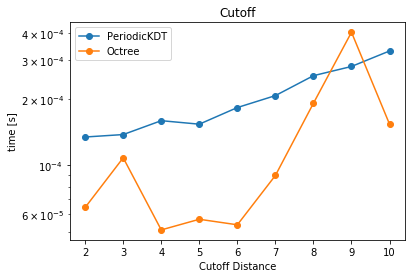

In [43]:
fig, ax = plt.subplots()
ax.plot(res['cutoff'], res['query'], 'o-', label='PeriodicKDT')
ax.plot(res_octree['cutoff'], res_octree['query'], 'o-', label='Octree')
ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Cutoff')
ax.legend()